In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten , Input, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.utils.class_weight import compute_class_weight


import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Data path
data_dir = "../Data"
train_dir = "../Data/train"
test_dir = "../Data/test"

# Image size and batch variable
img_height , img_weidth = 48 , 48
batch = 32

# Image Normalization to [0,1]
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    )

# Note for the labes, the flow_from_directory assigns it according to the folder name
# Load training data
train_data = datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_weidth),
    batch_size = batch,
    class_mode = 'categorical',
    subset = 'training'
)



validation_data = datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_weidth),
    batch_size = batch,
    class_mode = 'categorical',
    subset='validation'
)

# Load test data
test_data = datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_weidth),
    batch_size = batch,
    class_mode = 'categorical',
    shuffle = False,
)

# Handeling Data imbalance 
# Get the class labels from the training data
class_labels = train_data.class_indices  

# Get the class indices 
class_indices = list(class_labels.values())

# Compute class weights based on class distribution in the training data
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(class_indices), 
                                     y=train_data.classes) 

# Convert class weights into a dictionary format for TensorFlow
class_weight_dict = {i: weight for i, weight in zip(class_indices, class_weights)}

print(class_weight_dict)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
{0: np.float64(1.0266404434114071), 1: np.float64(9.401555464592715), 2: np.float64(1.0009587727708533), 3: np.float64(0.5684585684585685), 4: np.float64(0.826068191627104), 5: np.float64(0.8491570541259982), 6: np.float64(1.2933160650937552)}


In [16]:
# Verify the data and its lable
# Check the output summary
print("Class names:", train_data.class_indices)
print("Number of batches per epoch:", train_data.samples // batch) 
print("Image shape:", train_data.image_shape)  
print("Number of classes:", len(train_data.class_indices))  

Class names: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Number of batches per epoch: 717
Image shape: (48, 48, 3)
Number of classes: 7


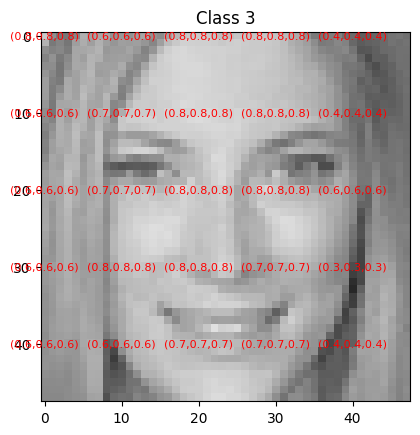

In [17]:
# Visualizing the image in its pixel value with 4 intervals

images , labels = next(train_data)
image = images[0]
label = labels[0]
c_value = np.argmax(label)

plt.imshow(image)
plt.title(f"Class {c_value}")

for i in range(0, img_height, 10):
    for j in range(0, img_weidth, 10):
        r, g, b = image[i, j]
        plt.text(j,i, f"({r:.1f},{g:.1f},{b:.1f})", color='red', fontsize=8, ha='center', va='center' )
plt.show()

Looking at the result of the model we can see that the model is overfitting as the traning accuracy after 10 epoch is 99.46% how ever the validation accuracy is at 45.01 %.

In [18]:
# intregrating convolution layers using pooling and drop out for over fitting
model = Sequential()

model.add(Input(shape=(img_height, img_weidth, 3)))
model.add(Conv2D(32, kernel_size= 3, activation='relu', padding='same' ))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size= 3, activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size= 3, activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))


# intregrating Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(7, activation='softmax'))
 
# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,103 (2.61 MB)

 Trainable params: 684,103 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Stop the training when accuracy and validation widens more then 0.1

class Overfitting(Callback):
    def __init__(self, threshold=0.05, patience=2):  
        super(Overfitting, self).__init__()
        self.threshold = threshold
        self.patience = patience
        self.counter = 0  

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if acc and val_acc:
            gap = acc - val_acc  
            print(f"\nEpoch {epoch+1}: Accuracy gap = {gap:.4f}")

            if gap > self.threshold:  
                self.counter += 1
                if self.counter >= self.patience:
                    print(f"\nStopping training: Accuracy gap exceeded {self.threshold} for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.counter = 0  

stop_overfitting = Overfitting(threshold=0.1, patience=2)

# Solwer the learning rate if the val_loss doen't improve in 3 epoch
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


training = model.fit(train_data, epochs=20, validation_data = validation_data, callbacks=[reduce_lr, stop_overfitting], class_weight=class_weight_dict)


Epoch 1/20


/home/poppop/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1439 - loss: 1.9470
Epoch 1: Accuracy gap = -0.0724
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.1440 - loss: 1.9469 - val_accuracy: 0.2534 - val_loss: 1.8072 - learning_rate: 5.0000e-04
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2726 - loss: 1.7597
Epoch 2: Accuracy gap = -0.0645
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.2727 - loss: 1.7597 - val_accuracy: 0.3583 - val_loss: 1.6497 - learning_rate: 5.0000e-04
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3576 - loss: 1.6363
Epoch 3: Accuracy gap = -0.0631
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.3576 - loss: 1.6363 - val_accuracy: 0.4297 - val_loss: 1.4911 - learning_rate: 5.0000e-04
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4148 - loss: 1.4587
Epoch 4: Accuracy gap = -0.0252
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4148 - loss: 1.4587 - val_accuracy: 0

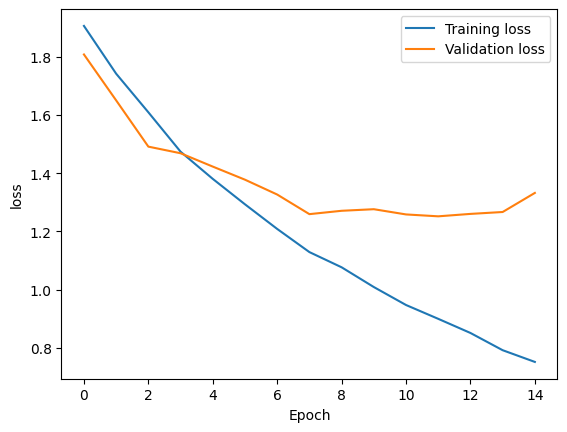

In [20]:
plt.plot(training.history['loss'], label= "Training loss")
plt.plot(training.history['val_loss'], label= "Validation loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

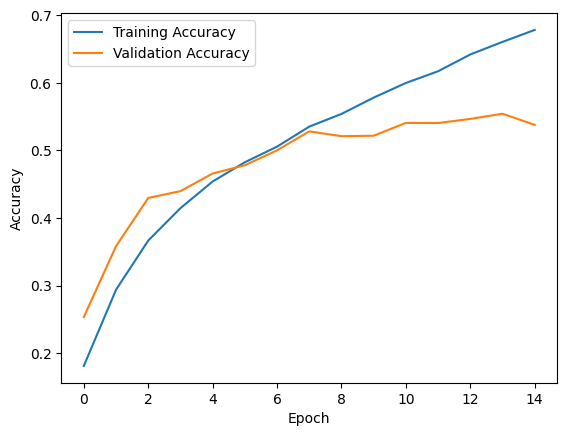

In [21]:
plt.plot(training.history['accuracy'], label="Training Accuracy")
plt.plot(training.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [22]:
# Import necessary libraries
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Generate predictions on the test data
predictions = model.predict(test_data)

# Convert the predictions to class labels (assumes categorical output)
y_pred = np.argmax(predictions, axis=1)

# Extract true labels from the test data generator
y_true = test_data.classes

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the scores
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Optionally, print a detailed classification report
target_names = list(test_data.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Accuracy: 0.5383
Precision: 0.5609
Recall: 0.5383
F1 Score: 0.5458

Classification Report:
              precision    recall  f1-score   support

       angry       0.43      0.49      0.46       958
     disgust       0.36      0.53      0.43       111
        fear       0.38      0.35      0.36      1024
       happy       0.82      0.65      0.73      1774
     neutral       0.48      0.53      0.50      1233
         sad       0.41      0.47      0.44      1247
    surprise       0.76      0.69      0.72       831

    accuracy                           0.54      7178
   macro avg       0.52      0.53      0.52      7178
weighted avg       0.56      0.54      0.55      7178



In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Generate predictions for the test data
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes

# If available, get filenames to help identify the images
filenames = test_data.filenames

# Create a mapping from label index to class name using the test data's class_indices
label_map = {v: k for k, v in test_data.class_indices.items()}

# Create a DataFrame with filenames, true labels, and predicted labels
df = pd.DataFrame({
    'filename': filenames,
    'true_label': y_true,
    'predicted_label': y_pred
})

# Map numeric labels to actual class names
df['true_label_name'] = df['true_label'].map(label_map)
df['predicted_label_name'] = df['predicted_label'].map(label_map)

# Display a few rows of the DataFrame to compare predicted vs. actual values
print("Sample predictions:")
print(df.head(10))

# Calculate the total number of correct and incorrect predictions
correct = (df['true_label'] == df['predicted_label']).sum()
total = len(df)
incorrect = total - correct
print(f"\nTotal Predictions: {total}")
print(f"Correct Predictions: {correct}")
print(f"Incorrect Predictions: {incorrect}")

# Calculate accuracy per class
class_accuracies = {}
for label, class_name in label_map.items():
    # Get subset for the current class
    class_df = df[df['true_label'] == label]
    # Compute the accuracy for the class
    class_accuracy = (class_df['true_label'] == class_df['predicted_label']).sum() / len(class_df)
    class_accuracies[class_name] = class_accuracy

print("\nAccuracy per class:")
for class_name, acc in class_accuracies.items():
    print(f"{class_name}: {acc:.4f}")

# Optionally, print a full classification report for more detailed metrics
print("\nFull Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Sample predictions:
                         filename  true_label  predicted_label  \
0  angry/PrivateTest_10131363.jpg           0                3   
1  angry/PrivateTest_10304478.jpg           0                2   
2   angry/PrivateTest_1054527.jpg           0                5   
3  angry/PrivateTest_10590091.jpg           0                0   
4   angry/PrivateTest_1109992.jpg           0                0   
5  angry/PrivateTest_11296953.jpg           0                2   
6  angry/PrivateTest_12000629.jpg           0                0   
7  angry/PrivateTest_12008383.jpg           0                0   
8  angry/PrivateTest_12191716.jpg           0                5   
9   angry/PrivateTest_1221822.jpg           0                0   

  true_label_name predicted_label_name  
0           angry                happy  
1           angry                 fear  
2           angry                  sad  
3           angry                angry  
4      